# FFT in Autokorelacije

In [1]:
import numpy as np
import numpy.fft as fft
from scipy import signal
import matplotlib.pyplot as plt
import time
import scipy.io.wavfile
import csv

### Časovno, napake, ...
Počasni DFT iz prejšnje naloge. Časovno primerjavo sem že prejšnjič. Zadevo sem pozabil shranit tle nekje, zato ni funkcije za časovno odvisnost, napake ne vem če tea verzija dela.

In [2]:
def dft(x):
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))

    H = np.exp(-2j * np.pi * k * n / N)
    
    return np.dot(H, x)


def idft(x):
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))

    H = (np.exp(2j * np.pi * k * n / N)) / N

    return np.dot(H, x)

In [3]:
def napake():
    velikosti = np.arange(100, 44100, 4000)
    napakef = np.zeros(len(velikosti))
    napaked = np.zeros(len(velikosti))
    for i in range(len(velikosti)):
        N = velikosti[i]
        per = 2*np.pi
        ws = np.array([47, 10, 30]) * per
        wc = np.array([10, 8, 45]) * per
        s = np.array([1, 2, 0.4])
        c = np.array([1.7, 0.99, 0.6])
        delta = 1 / N

        x = np.linspace(0., N * delta, N, endpoint=False)
        y = 0
        for i in range(len(ws)):
            y += s[i] * np.sin(ws[i] * x)
            y += c[i] * np.cos(wc[i] * x)

        f_ft = fft.fft(y)
        d_ft = dft(y)
        ifft_fft = fft.ifft(f_ft)
        idft_dft = idft(d_ft)
        ffterr = abs(y - ifft_fft)
        dfterr = abs(y - idft_dft)
        napakef[i] = np.average(ffterr)
        napaked[i] = np.average(dfterr)
        print(N)

    plt.title('Absolutna napaka inverzne trasnformacije')
    plt.plot(velikosti, ffterr, 'absolutna napaka FFT')
    plt.plot(velikosti, dfterr, 'absolutna napaka DFT')
    plt.xlabel('$N$')
    plt.ylabel('Absolutna napaka')
    plt.show()
    plt.savefig('grafi/napake.png')

#napake()


## Sove
Funkcija za branje .wav posnetkov. Frekvenca vzorčenja je pri vseh posnetkih ista in je enaka 44100 Hz. ajprej bom naredil samo anačizo frekvenčnih spektrov

In [4]:
def read_sove(filename):
    rate, data = scipy.io.wavfile.read('sove/'+str(filename)+'.wav')
    return np.array(data), rate

sove = ['bubomono', 'bubo2mono', 'mix', 'mix1', 'mix2', 'mix22']

bubomono, rate = read_sove('bubomono')
bubo2mono, rate = read_sove('bubo2mono')
mix, rate = read_sove('mix')
mix1, rate = read_sove('mix1')
mix2, rate = read_sove('mix2')
mix22, rate = read_sove('mix22')

sove_posnetki = [bubomono, bubo2mono, mix, mix1, mix2, mix22]

dolzina = 0
for posnetek in sove_posnetki:
    dolzina = max(dolzina, len(posnetek))

for posnetek in sove_posnetki:
    pad = dolzina - len(posnetek)
    posnetek = np.pad(posnetek, [(0, pad)], mode='constant')
    print(len(posnetek))

print(rate)

220500
220500
220500
220500
220500
220500
44100


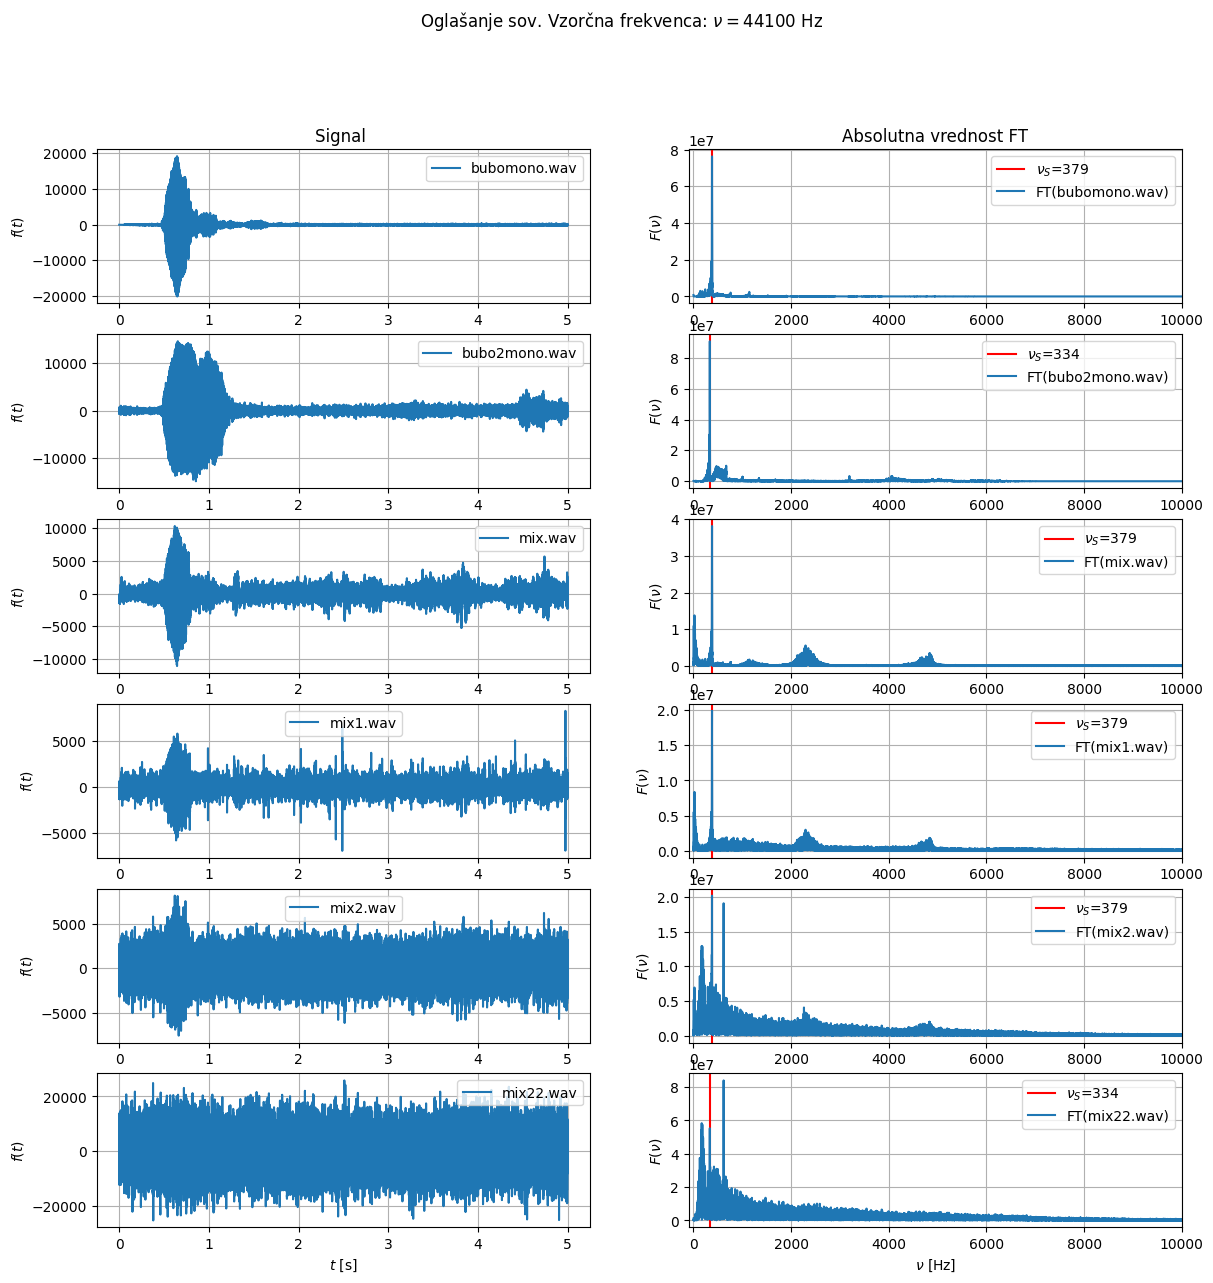

In [5]:
def sove_fourier(data, rate, names=0):
    if names == 0:
        names = [f'posnetek{i}' for i in range(len(data))]

    fig, ax = plt.subplots(len(data), 2, figsize=(14, 14))
    for i in range(len(data)):
        N = len(data[i])
        delta = 1 / rate

        x = np.linspace(0, N * delta, N, endpoint=False)
        nuc = 1 / (2 * delta)

        f_ft = fft.ifftshift(fft.fft(data[i]))
        nu = np.linspace(-nuc, nuc, N)

        meja = N - N//2

        max = np.argmax(abs(f_ft)[meja:])
        polnu = nu[meja:]
        numax = polnu[max]

        ax[i, 0].plot(x, data[i], label=f'{names[i]}.wav')
        ax[i, 0].set_ylabel('$f(t)$')
        ax[i, 0].grid()
        ax[i, 0].legend()

        if i == len(data)-1:
            max = np.argmax(abs(f_ft)[meja+1500:meja+3000])
            numax = polnu[max+1500]

        ax[i, 1].axvline(numax, color='red', label=r'$\nu_S$={}'.format(int(numax)))
        ax[i, 1].plot(nu[meja:], abs(f_ft)[meja:], label=f'FT({names[i]}.wav)')
        ax[i, 1].set_ylabel(r'$F(\nu)$')
        ax[i, 1].grid()
        ax[i, 1].legend()
        ax[i, 1].set_xlim([-100, 10000])

        if i == 0:
            ax[i, 0].set_title('Signal ')
            ax[i, 1].set_title('Absolutna vrednost FT')
        if i == len(data)-1:
            ax[i, 0].set_xlabel('$t$ [s]')
            ax[i, 1].set_xlabel(r'$\nu$ [Hz]')


    fig.suptitle(r'Oglašanje sov. Vzorčna frekvenca: $\nu={}$ Hz'.format(rate))
    plt.savefig('grafi/sove.png')
    plt.show()

sove_fourier(sove_posnetki, rate, sove)

### (Avto)korelacijska funkcija

In [6]:
def korelacija(g, h):
    N = max(len(g), len(h))
    delta = 1 / rate
    x = np.linspace(0, N * delta, N, endpoint=False)
    G = np.pad(fft.fft(g), [(0, N-len(g))], mode='constant')
    H = np.pad(fft.fft(h), [(0, N-len(h))], mode='constant')

    Phi = fft.ifft(G * np.conj(H))
    N_n = np.arange(N)[::-1]
    return np.real(Phi)[:N//2] / N_n[:N//2], x[:N//2]

#### Avtokorelacija čistih posnetkov sov

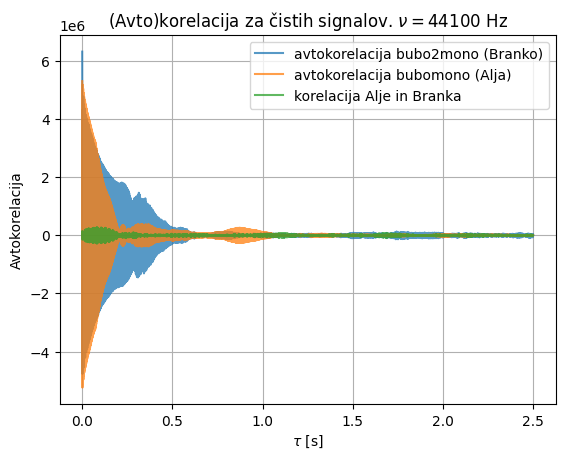

In [7]:
def avtokoreliraj(data, rate, names):
    prosojnost=0.75
    a, taua = korelacija(data[0], data[0])
    b, taub = korelacija(data[1], data[1])
    k, tauk = korelacija(data[0], data[1])
    plt.plot(taub, b, label=f'avtokorelacija {names[1]} (Branko)', alpha=prosojnost)
    plt.plot(taua, a, label=f'avtokorelacija {names[0]} (Alja)', alpha=prosojnost)
    plt.plot(tauk, k, label=f'korelacija Alje in Branka', alpha=prosojnost)
    plt.title(r'(Avto)korelacija za čistih signalov. $\nu={}$ Hz'.format(rate))
    plt.xlabel(r'$\tau$ [s]')
    plt.ylabel('Avtokorelacija')
    plt.grid()
    plt.legend()
    #plt.savefig('grafi/avtokorelacija-sove.png')

avtokoreliraj(sove_posnetki, rate, sove)

#### Korelacije med različnimi posnetki

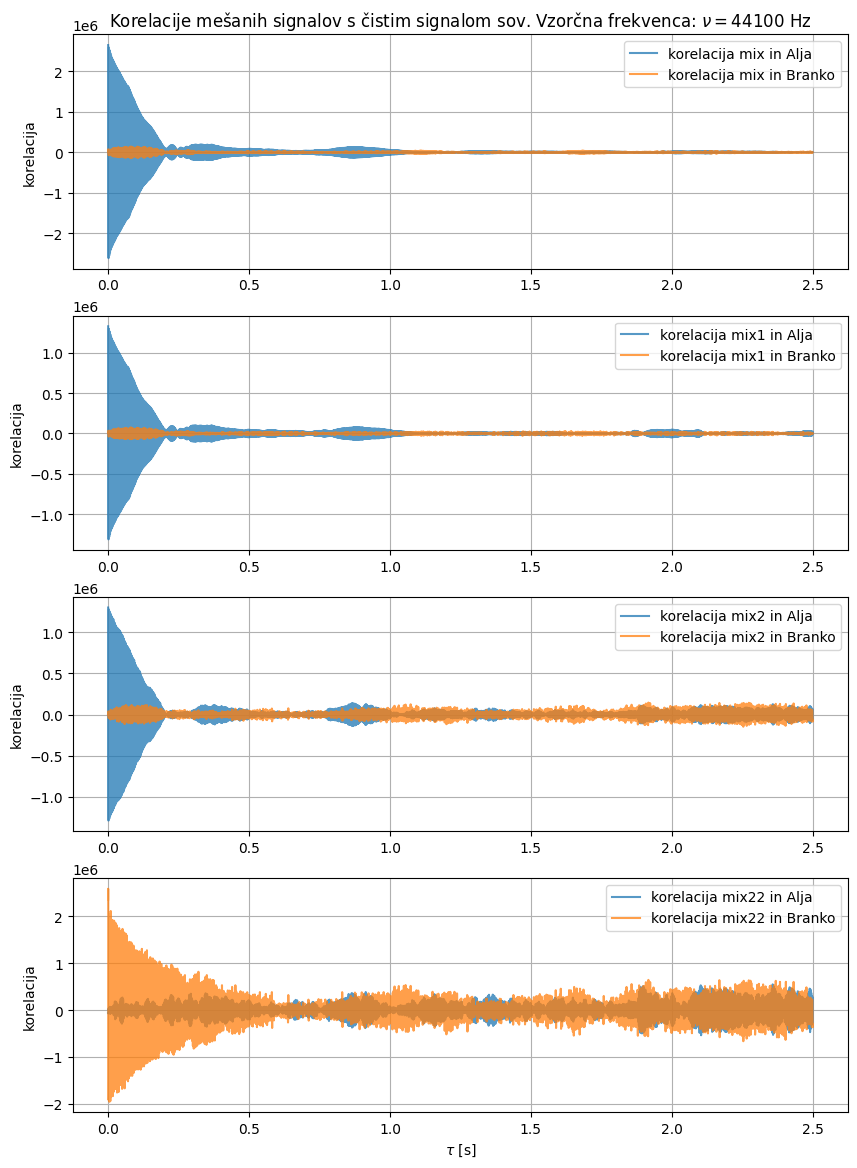

In [8]:
def korel_draw(data, rate, names):
    alja = data[0]
    branko = data[1]
    
    prosojnost=0.75

    fig, ax = plt.subplots(len(data)-2, 1, figsize=(10, 14))
    for i in range(len(data)-2):
        j = i+2
        a, taua = korelacija(data[j], alja)
        b, taub = korelacija(data[j], branko)

        ax[i].plot(taua, a, label=f'korelacija {names[j]} in Alja', alpha=prosojnost)
        ax[i].plot(taub, b, label=f'korelacija {names[j]} in Branko', alpha=prosojnost)
        ax[i].set_ylabel('korelacija')
        ax[i].grid()
        ax[i].legend()

    ax[3].set_xlabel(r'$\tau$ [s]')
    ax[0].set_title(r'Korelacije mešanih signalov s čistim signalom sov. Vzorčna frekvenca: $\nu={}$ Hz'.format(rate))
    #plt.savefig('grafi/korelacije.png')
    plt.show()


korel_draw(sove_posnetki, rate, sove)

## Dodatna naloga: sunspots

In [9]:
def read_sunspots():
    with open('sunspots/SN_d_tot_V2.0.csv', newline='') as data:
        reader = csv.reader(data, delimiter=' ', quotechar='|')
        spots = []
        for row in reader:
            spots.append(row[2])
            #print(row)

    start = date
    casi = 
    return np.array(spots), casi

spots = read_sunspots()
plt.plot(casi, spots)
plt.show()

SyntaxError: invalid syntax (2431813176.py, line 10)

## Dodatna naloga: Prepoznavanje črk na slikah